In [1]:
import numpy as np
import PIL as Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Steps for training a classifier.

1. Load the data
2. Define the model CNN
3. Definee loss function
4. Train the network on the training data
5. Evaluate the network on testing data. 

## What are CNNs vs MLPs?

- Input data is processed differently
- For MLP we flattened the data into a vector. Relationships between pixels are lost. Not ideal for image data.
- For CNNs we keep the 2D structure of the image. 

## CNNS

- Cnns preserve the 2d structure of the images
- Capture spatial patterns like edges shapes
- Stride refers to the number of pixels we move the filter across the image at a time.  

EX: Lets say we have a 5x5 Image, we can take a 3x3 section of the image and apply a filter to it. A filter can be similar to a matrix of weights for each of the pixels in the 3x3 section. We take the dot product of this with the filter and get a single value and then apply relu on it. This is a convolution. We do this for every 3x3 section in the image and we will get a 5x5 output (if we use a stride of 1, it will be smaller if we use a stride of 2 etc) for that specific neuron where each of the values in the matrix represents a 3x3 section (of dot producted and relued) of the previous layer. 

Pooling Layer: downsapling technique to reduce the spatial size of the image. The next layer after the convultion layer. 
Max Pooling: we simply extract the maxiumum value from the pool size section (ex 2x2 we take the max of the 4 values in the 2x2 section and output a 1x1 value). WE do this for every 2x2 section in the image and we will get a smaller image. 

Conv Layer 2: We repeat the process of the first conv layer. For each neuron in the previous pooled (channel) we have to apply a filter to the new image. so we will have a (3,3,2) filter if we have 2 neurons in the previous layer. If we decide to have 4 layers in next we will need 4 filters of (3,3,2) to apply to the new image.

Max Pooling Layer 2: We repeat the process of the first pooling layer. We take the max of the 2x2 sections and we will get a smaller image. For each of the channels (lets say 4) we will take the max of the 2x2 sections and we will get a smaller image. 

Output Layer: first we flatten the feature maps, pass them through 1 more fully connected layer and apply the softmax function. This is similar now to doing a MLP method to get the final output. 

NOTE: Filters are similar to Weight matricies. Pooling is making the image less pixels, Channels are matricies of dot producted sections from the previous layer. 
For each layer we will have multiple channels. The amount of filters for the next layer after the first channeling depends on the amount of channels we want to have in the next layer. This can be represented in a tensor of filters. where the 3rd dimension is the amount of channels we have to operate on.

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # For rgb images normalize with a mean and standard deviation of 0.5, pixel values are between 0 and 1. 
])

#Note: we normalize the data helping to prevent large gradients, avoids, vanising and exploding gradients. See NN_test.

In [3]:
batch_size = 32

train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True, drop_last=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [41]:
image, label = train_data[0]
print(image.shape)
print(label) #From 0-9

torch.Size([3, 32, 32])
6


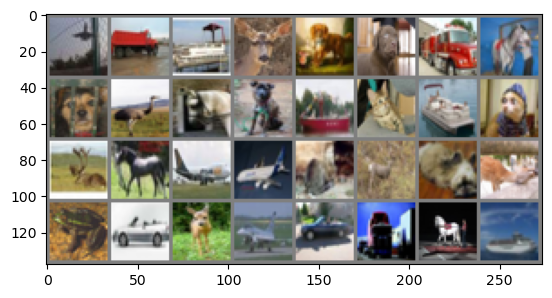

plane truck ship  deer  dog   dog   truck horse dog   bird  horse dog   ship  cat   ship  cat   deer  horse plane plane cat   deer  cat   deer  frog  car   deer  plane car   truck horse ship 


In [42]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5 # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [54]:
# Defining the neural network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        #initial layer has 3 channels RGB
        self.conv1 = nn.Conv2d(3, 12, kernel_size=5) #12 feature maps produced from 3 channels. kernel size is the size of the filter. 5x5

        # 32 - 5  27/1  + 1 = 28 New shape is (12, 28, 28) 12 channels with 28x28 pixels 
        #this is the output size of a feature map after applying a conv layer 
        #output size = (input size - filter size + 1) / stride

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2) #(12 channels, 14, 14)
        #Output size = ((input size - kernel size) / stride) + 1
        #ex: 28x28-> 28 - 2 / 2 + 1 = 14

        self.conv2 = nn.Conv2d(12, 24, kernel_size=5) #14 - 5 + 1 / 1 = 10 (24, 10, 10)
        # (24, 10, 10) -> (24, 5, 5) No need to pool this time as we will use the same pool as before 2x2
        
        self.fc1 = nn.Linear(in_features=24*5*5, out_features=120) #120 neurons in our feature
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10) #10 output neurons for 10 classes
        

    def forward(self, X):
        #Doing the actual forward pass

        #Running it through the convultional layers
        X = self.pool(F.relu(self.conv1(X)))
        X = self.pool(F.relu(self.conv2(X)))



        #We flatten this after now we can run MLP like normal
        X = torch.flatten(X, 1)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))

        return X





In [59]:
model = NeuralNetwork()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

def gradient_descent(model):

    running_loss = 0.0
    
    for batch, data in enumerate(train_dataloader):
        inputs, labels = data

        pred = model.forward(inputs)

        loss = loss_fn(pred, labels)

        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        
        running_loss += loss.item()
        

    print(f"Loss: {running_loss / len(train_dataloader):.4f}")



In [60]:
print("Starting Gradient Descent")

for epoch in range(10):
    print(f"Epoch {epoch + 1}")
    gradient_descent(model)



Starting Gradient Descent
Epoch 1
Loss: 2.2683
Epoch 2
Loss: 2.0832
Epoch 3
Loss: 1.8983
Epoch 4
Loss: 1.7844
Epoch 5
Loss: 1.5698
Epoch 6
Loss: 1.4446
Epoch 7
Loss: 1.2371
Epoch 8
Loss: 1.1574
Epoch 9
Loss: 1.0902
Epoch 10
Loss: 1.0360


In [61]:
# Doing evaluation on test data

correct = 0
total = 0

#no.grad means not doing backpropagation
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.1f}%')

Accuracy of the network on the 10000 test images: 62.6%
